# Setting

In [1]:
import bt
import FinanceDataReader as fdr
import pandas as pd

In [2]:
from pypfopt import EfficientFrontier, EfficientSemivariance, EfficientCVaR, EfficientCDaR
from pypfopt import risk_models
from pypfopt import expected_returns

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams["font.family"] = 'NanumBarunGothic'

In [4]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [5]:
path_data = 'data'

In [6]:
def buy_and_hold(df, names=None, name_stg=None):
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if names is not None:
        if not isinstance(names, list):
            names = [names]
        cols = df.columns
        if len(cols) == len(names):
            df = df.rename(columns=dict(zip(cols, names)))
        else:
            print('WARNING: check num of names')

    if name_stg is None:
        name_stg = names[0]
        
    strategy = bt.Strategy(name_stg, [
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.RunOnce(),
        bt.algos.Rebalance()
    ])
    return bt.Backtest(strategy, df)



def backtest(dfs, weights=None, name='portfolio', period='M'):
    if weights is None:
        cols = dfs.columns
        weights = dict(zip(cols, [1]*len(cols)))

    if period == 'W':
        run_period = bt.algos.RunWeekly()
    elif period == 'Q':
        run_period = bt.algos.RunQuarterly()
    elif period == 'Y':
        run_period = bt.algos.RunYearly()
    else: # default montly
        run_period = bt.algos.RunMonthly()
        
    strategy = bt.Strategy(name, [
        bt.algos.SelectAll(),
        bt.algos.WeighSpecified(**weights),
        run_period,
        bt.algos.Rebalance()
    ])
    return bt.Backtest(strategy, dfs)



def get_start_dates(dfs, symbol_name=None):
    """
    symbol_name: dict of symbols to names
    """
    df = dfs.apply(lambda x: x[x.notna()].index.min()).to_frame('start date')
    if symbol_name is not None:
        df = pd.Series(symbol_name).to_frame('name').join(df)
    return df.sort_values('start date')


def valuate_bond(face, rate, year, ytm, n_pay=1):
    """
    face: face value
    rate: coupon rate (annual)
    year: years to maturity
    ytm: discount rate (annual)
    n_pay: number of payments per year
    """
    c = face * rate / n_pay
    vc = 0
    r_discount = ytm/n_pay
    # calc The present value of expected cash flows
    for t in range(1, year*n_pay+1):
        vc += c/(1+r_discount)**t
    # the present value of the face value of the bond added
    return vc + face/(1+r_discount)**(year*n_pay)


# Data

## ETF

In [9]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목
df_sym.head()

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
0,459580,6,KODEX CD금리액티브(합성),1038395,3,0,0.0,1038390.0,0.9095,0,0,89649
1,357870,6,TIGER CD금리투자KIS(합성),54430,3,0,0.0,54427.0,0.8897,0,0,72867
2,069500,1,KODEX 200,37240,3,0,0.0,37299.0,4.8334,0,0,63848
3,423160,6,KODEX KOFR금리액티브(합성),107025,3,0,0.0,107005.0,0.9146,0,0,52293
4,449170,6,TIGER KOFR금리액티브(합성),105545,3,0,0.0,105552.0,0.9082,0,0,36980


In [85]:
cond = df_sym.Name.str.contains('채권')
cond = cond | df_sym.Name.str.contains('국고채')
cond = cond | df_sym.Name.str.contains('국채')
#cond = cond & df_etf.Name.str.contains('미국')
cond = cond & ~df_sym.Name.str.contains('액티브')

#cond = df_etf.Name.str.contains('S&P')

#cond = df_etf.Name.str.contains('금현물')

df_sym.loc[cond].sort_values('MarCap', ascending=False)

,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
21,214980,6,KODEX 단기채권PLUS,110795,2,25,0.02,110785.0,0.9153,13622,1509,12848
44,153130,6,KODEX 단기채권,109855,2,10,0.01,109853.0,0.8537,21790,2393,7373
64,148070,6,KOSEF 국고채10년,112610,2,410,0.37,112573.0,1.2270,9711,1091,4932
73,385560,6,KBSTAR KIS국고채30년Enhanced,72255,2,785,1.10,72261.0,2.4239,56207,4043,3988
75,365780,6,ACE 국고채10년,88490,2,315,0.36,88487.0,1.1372,3522,311,3884
76,114260,6,KODEX 국고채3년,59860,2,60,0.10,59853.0,0.7744,33593,2010,3861
90,302190,6,TIGER 중장기국채,50530,2,130,0.26,50528.0,0.9287,5472,276,3295
91,304660,6,KODEX 미국30년국채울트라선물(H),8005,2,60,0.76,7999.0,-2.6156,295897,2365,3290
99,472870,6,KBSTAR 미국30년국채엔화노출(합성 H),8805,2,20,0.23,8821.0,-5.7281,619074,5440,2963
147,473330,6,SOL 미국30년국채커버드콜(합성),9940,2,20,0.20,9935.0,1.3665,428755,4261,1680


In [10]:
symbols = ['273130', '453850', '284430', '069500', '379800', '411060', '305080', '304660', '148070']
names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합'}

In [11]:
start_data = '2000-01-01'
df_etf = fdr.DataReader(','.join(symbols), start_data)
df_etf.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070
Date,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN


*start date of each etf*

In [44]:
df = get_start_dates(df_etf, names)
df

,name,start date
069500,KODEX 200,2002-10-14
148070,KOSEF 국고채10년,2011-10-20
273130,KODEX 종합채권(AA-이상)액티브,2017-06-29
284430,KODEX 200미국채혼합,2017-11-30
305080,TIGER 미국채10년선물,2018-08-30
304660,KODEX 미국30년국채울트라선물(H),2018-09-12
379800,KODEX 미국S&P500TR,2021-04-09
411060,ACE KRX금현물,2021-12-15
453850,ACE 미국30년국채액티브(H),2023-03-14


In [17]:
df_etf = df_etf.loc[df['start date'].min():]

file = 'etfs_selected_240610.csv'
df_etf.to_csv(f'{path_data}/{file}')

## Economic

In [23]:
col = 'Adj Close'

df_snp = fdr.DataReader('S&P500', start_data)[col]
df_gold = fdr.DataReader('GC=F', start_data)[col] # gold
df_wti = fdr.DataReader('CL=F', start_data)[col] # WTI유 선물 Crude Oil (NYMEX)
df_us10 = fdr.DataReader('US10YT', start_data)[col] # 10년 만기 미국국채 수익률
df_us30 = fdr.DataReader('US30YT', start_data)[col] # 30년 만기 미국국채 수익률

In [45]:
df_eco = (df_snp.to_frame('S&P')
      .join(df_gold.to_frame('Gold'))
      .join(df_wti.to_frame('WTI'))
      .join(df_us10.to_frame('US10YT'))
      .join(df_us30.to_frame('US30YT'))
      .join(df_etf['069500'].to_frame('KOSPI'))
     )
df_eco.index = pd.to_datetime(df_eco.index)
df_eco.head()

,S&P,Gold,WTI,US10YT,US30YT,KOSPI
Date,,,,,,
2000-01-03,1455.219971,NaN,NaN,6.548,6.598,NaN
2000-01-04,1399.420044,NaN,NaN,6.485,6.532,NaN
2000-01-05,1402.109985,NaN,NaN,6.599,6.631,NaN
2000-01-06,1403.449951,NaN,NaN,6.549,6.572,NaN
2000-01-07,1441.469971,NaN,NaN,6.504,6.537,NaN


In [46]:
df = get_start_dates(df_eco)
df

,start date
S&P,2000-01-03
US10YT,2000-01-03
US30YT,2000-01-03
WTI,2000-08-23
Gold,2000-08-30
KOSPI,2002-10-14


In [48]:
df_eco = df_eco.loc[df['start date'].min():]

file = 'economic_data_240610.csv'
df_eco.to_csv(f'{path_data}/{file}')

## Load

In [7]:
file = 'etfs_selected_240610.csv'
df_etf = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_etf.head()

,273130,453850,284430,069500,379800,411060,305080,304660,148070
Date,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN


In [8]:
file = 'economic_data_240610.csv'
df_eco = pd.read_csv(f'{path_data}/{file}', parse_dates=[0], index_col=0)
df_eco.head()

,S&P,Gold,WTI,US10YT,US30YT,KOSPI
Date,,,,,,
2000-01-03,1455.219971,NaN,NaN,6.548,6.598,NaN
2000-01-04,1399.420044,NaN,NaN,6.485,6.532,NaN
2000-01-05,1402.109985,NaN,NaN,6.599,6.631,NaN
2000-01-06,1403.449951,NaN,NaN,6.549,6.572,NaN
2000-01-07,1441.469971,NaN,NaN,6.504,6.537,NaN


In [11]:
cols = ['US10YT', 'US30YT']
#df_eco[cols] = 
df_eco[cols].apply(lambda x: valuate_bond(face, rate, year, ytm, n_pay=1))

,US10YT,US30YT
Date,,
2000-01-03,0.0,0.0
2000-01-04,0.0,0.0
2000-01-05,0.0,0.0
2000-01-06,0.0,0.0
2000-01-07,0.0,0.0
...,...,...
2024-06-03,0.0,0.0
2024-06-04,0.0,0.0
2024-06-05,0.0,0.0


In [9]:
df_sym = fdr.StockListing('ETF/KR') # 한국 ETF 전종목

symbols = df_etf.columns
etf_names = df_sym.loc[df_sym.Symbol.isin(symbols)].set_index('Symbol')['Name'].to_dict()
etf_names

{'069500': 'KODEX 200',
 '273130': 'KODEX 종합채권(AA-이상)액티브',
 '379800': 'KODEX 미국S&P500TR',
 '453850': 'ACE 미국30년국채액티브(H)',
 '148070': 'KOSEF 국고채10년',
 '304660': 'KODEX 미국30년국채울트라선물(H)',
 '411060': 'ACE KRX금현물',
 '305080': 'TIGER 미국채10년선물',
 '284430': 'KODEX 200미국채혼합'}

In [10]:
commissions = {
    '069500': 0.15, 
    '273130': 0.045, 
    '379800': 0.009,
    '148070': 0.050,
    '411060': 0.500,
    '284430': 0.310
}

# Backtesting

## Setting

In [10]:
df = get_start_dates(df_eco)
df

,start date
S&P,2000-01-03
US10YT,2000-01-03
US30YT,2000-01-03
WTI,2000-08-23
Gold,2000-08-30
KOSPI,2002-10-14


In [11]:
df_eco = df_eco.loc[df['start date'].max():]
df_eco.isna().sum()

S&P         0
Gold       15
WTI        11
US10YT      6
US30YT      6
KOSPI     263
dtype: int64

In [12]:
df_eco = df_eco.fillna(method='ffill')

Baseline

In [13]:
pf_dict = dict()

In [14]:
col = 'KOSPI'
bt_res = buy_and_hold(df_eco[col], col)
pf_dict[col] = bt_res

In [15]:
results = bt.run(*pf_dict.values())

In [16]:
metrics = [
    'total_return', 'cagr', 
    'max_drawdown', 'avg_drawdown', 'avg_drawdown_days', 
    'daily_vol', 'daily_sharpe', 'daily_sortino', 
    'monthly_vol', 'monthly_sharpe', 'monthly_sortino'
]
results.stats.loc[metrics]

,KOSPI
total_return,6.154752
cagr,0.095145
max_drawdown,-0.526171
avg_drawdown,-0.035753
avg_drawdown_days,56.318182
daily_vol,0.207572
daily_sharpe,0.542248
daily_sortino,0.869322
monthly_vol,0.189367
monthly_sharpe,0.560419


## MeanVar

In [33]:
pf_tmp = dict()
pf_tmp['KOSPI'] = pf_dict['KOSPI']

In [34]:
df = df_eco

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

opt = EfficientFrontier(mu, S)

# Optimize for maximal Sharpe ratio
_ = opt.max_sharpe()

weights = opt.clean_weights()
print(weights)

_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.30467, 'Gold': 0.44435, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.0, 'KOSPI': 0.25098})
Expected annual return: 9.4%
Annual volatility: 11.8%
Sharpe Ratio: 0.62


In [35]:
opt = EfficientFrontier(mu, S)
_ = opt.min_volatility()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.24759, 'Gold': 0.4239, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.121, 'KOSPI': 0.20751})
Expected annual return: 8.2%
Annual volatility: 11.3%
Sharpe Ratio: 0.55


In [36]:
target_return = 0.09
opt = EfficientFrontier(mu, S)
opt.efficient_return(target_return)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.29384, 'Gold': 0.43356, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.0394, 'KOSPI': 0.23319})
Expected annual return: 9.0%
Annual volatility: 11.5%
Sharpe Ratio: 0.61


In [37]:
target_volatility = 0.12
opt = EfficientFrontier(mu, S)
opt.efficient_risk(target_volatility)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.22982, 'Gold': 0.48415, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.0, 'KOSPI': 0.28602})
Expected annual return: 9.4%
Annual volatility: 12.0%
Sharpe Ratio: 0.62


In [42]:
candi = df_eco.columns
candi

Index(['S&P', 'Gold', 'WTI', 'US10YT', 'US30YT', 'KOSPI'], dtype='object')

In [43]:
cols = ['S&P', 'US10YT', 'US30YT', 'KOSPI']
df = df_eco[cols]

mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

opt = EfficientFrontier(mu, S)
_ = opt.max_sharpe()
weights = opt.clean_weights()
print(weights)

_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.52604, 'US10YT': 0.0, 'US30YT': 0.0, 'KOSPI': 0.47396})
Expected annual return: 9.2%
Annual volatility: 15.4%
Sharpe Ratio: 0.47


In [31]:
name = 'MeanVar1'
pf_tmp[name] = backtest(df, weights, name)

In [28]:
results = bt.run(*pf_tmp.values())
results.stats.loc[metrics]

,KOSPI,MeanVar
total_return,6.154752,7.132219
cagr,0.095145,0.101641
max_drawdown,-0.526171,-0.351318
avg_drawdown,-0.035753,-0.019108
avg_drawdown_days,56.318182,30.632035
daily_vol,0.207572,0.116886
daily_sharpe,0.542248,0.887742
daily_sortino,0.869322,1.420861
monthly_vol,0.189367,0.119297
monthly_sharpe,0.560419,0.861482


In [29]:
pf_dict

{'KOSPI': <bt.backtest.Backtest at 0x7beb6a509c40>,
 'MeanVar': <bt.backtest.Backtest at 0x7beb665f9820>}

## SemiVariance

In [48]:
df = df_eco

mu = expected_returns.mean_historical_return(df)
S = expected_returns.returns_from_prices(df)

In [49]:
target = 0.09
opt = EfficientSemivariance(mu, S)
opt.efficient_return(target)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.30551, 'Gold': 0.4115, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.03855, 'KOSPI': 0.24444})
Expected annual return: 9.0%
Annual semi-deviation: 8.1%
Sortino Ratio: 0.86


In [50]:
name = 'SemiVar'
pf_dict[name] = backtest(df, weights, name)

In [34]:
opt = EfficientSemivariance(mu, S)
opt.min_semivariance()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.27549, 'Gold': 0.4136, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.11734, 'KOSPI': 0.19357})
Expected annual return: 8.2%
Annual semi-deviation: 8.0%
Sortino Ratio: 0.78


/home/lbk/.cache/pypoetry/virtualenvs/pf-APoYtgC9-py3.12/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [51]:
results = bt.run(*pf_dict.values())
results.stats.loc[metrics]

,KOSPI,MeanVar,SemiVar
total_return,6.154752,7.132219,6.7088
cagr,0.095145,0.101641,0.098924
max_drawdown,-0.526171,-0.351318,-0.347883
avg_drawdown,-0.035753,-0.019108,-0.017467
avg_drawdown_days,56.318182,30.632035,28.885246
daily_vol,0.207572,0.116886,0.113927
daily_sharpe,0.542248,0.887742,0.88609
daily_sortino,0.869322,1.420861,1.415628
monthly_vol,0.189367,0.119297,0.114532
monthly_sharpe,0.560419,0.861482,0.870275


## CVaR

In [57]:
df = df_eco
mu = expected_returns.mean_historical_return(df)
S = expected_returns.returns_from_prices(df)

In [58]:
target = 0.09
opt = EfficientCVaR(mu, S)
opt.efficient_return(target)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.3006, 'Gold': 0.40495, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.03883, 'KOSPI': 0.25562})
Expected annual return: 9.0%
Conditional Value at Risk: 1.70%


In [59]:
name = 'CVaR'
pf_dict[name] = backtest(df, weights, name)

In [56]:
opt = EfficientCVaR(mu, S)
_ = opt.min_cvar()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.24285, 'Gold': 0.4122, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.13294, 'KOSPI': 0.21201})
Expected annual return: 8.1%
Conditional Value at Risk: 1.67%


In [60]:
results = bt.run(*pf_dict.values())
results.stats.loc[metrics]

,KOSPI,MeanVar,SemiVar,CVaR
total_return,6.154752,7.132219,6.7088,6.714507
cagr,0.095145,0.101641,0.098924,0.098961
max_drawdown,-0.526171,-0.351318,-0.347883,-0.350476
avg_drawdown,-0.035753,-0.019108,-0.017467,-0.017248
avg_drawdown_days,56.318182,30.632035,28.885246,29.161157
daily_vol,0.207572,0.116886,0.113927,0.11403
daily_sharpe,0.542248,0.887742,0.88609,0.885694
daily_sortino,0.869322,1.420861,1.415628,1.416147
monthly_vol,0.189367,0.119297,0.114532,0.114943
monthly_sharpe,0.560419,0.861482,0.870275,0.86771


## CDaR

In [61]:
df = df_eco
mu = expected_returns.mean_historical_return(df)
S = expected_returns.returns_from_prices(df)

In [68]:
target = 0.09
opt = EfficientCDaR(mu, S)
opt.efficient_return(target)
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.29293, 'Gold': 0.54324, 'WTI': 0.0, 'US10YT': 0.0444, 'US30YT': 0.0, 'KOSPI': 0.11943})
Expected annual return: 9.0%
Conditional Drawdown at Risk: 17.42%


In [69]:
name = 'CDaR2'
pf_dict[name] = backtest(df, weights, name)

In [65]:
opt = EfficientCDaR(mu, S)
_ = opt.min_cdar()
weights = opt.clean_weights()
print(weights)
_ = opt.portfolio_performance(verbose=True)

OrderedDict({'S&P': 0.23715, 'Gold': 0.57561, 'WTI': 0.0, 'US10YT': 0.15786, 'US30YT': 0.0, 'KOSPI': 0.02939})
Expected annual return: 8.0%
Conditional Drawdown at Risk: 15.63%


In [70]:
results = bt.run(*pf_dict.values())
results.stats.loc[metrics]

,KOSPI,MeanVar,SemiVar,CVaR,CDaR,CDaR2
total_return,6.154752,7.132219,6.7088,6.714507,6.330674,6.932759
cagr,0.095145,0.101641,0.098924,0.098961,0.096374,0.100378
max_drawdown,-0.526171,-0.351318,-0.347883,-0.350476,-0.268572,-0.306162
avg_drawdown,-0.035753,-0.019108,-0.017467,-0.017248,-0.018236,-0.018373
avg_drawdown_days,56.318182,30.632035,28.885246,29.161157,31.583333,30.395745
daily_vol,0.207572,0.116886,0.113927,0.11403,0.126361,0.11822
daily_sharpe,0.542248,0.887742,0.88609,0.885694,0.792358,0.869363
daily_sortino,0.869322,1.420861,1.415628,1.416147,1.255685,1.379177
monthly_vol,0.189367,0.119297,0.114532,0.114943,0.10975,0.11323
monthly_sharpe,0.560419,0.861482,0.870275,0.86771,0.888096,0.894259


In [74]:
pf_dict.pop('CDaR2')

In [75]:
pf_dict

{'KOSPI': <bt.backtest.Backtest at 0x7beb664fb8f0>,
 'MeanVar': <bt.backtest.Backtest at 0x7beb62241340>,
 'SemiVar': <bt.backtest.Backtest at 0x7beb622427e0>,
 'CVaR': <bt.backtest.Backtest at 0x7beb622c4320>,
 'CDaR': <bt.backtest.Backtest at 0x7beb622caf00>}

## Compare

In [76]:
results = bt.run(*pf_dict.values())

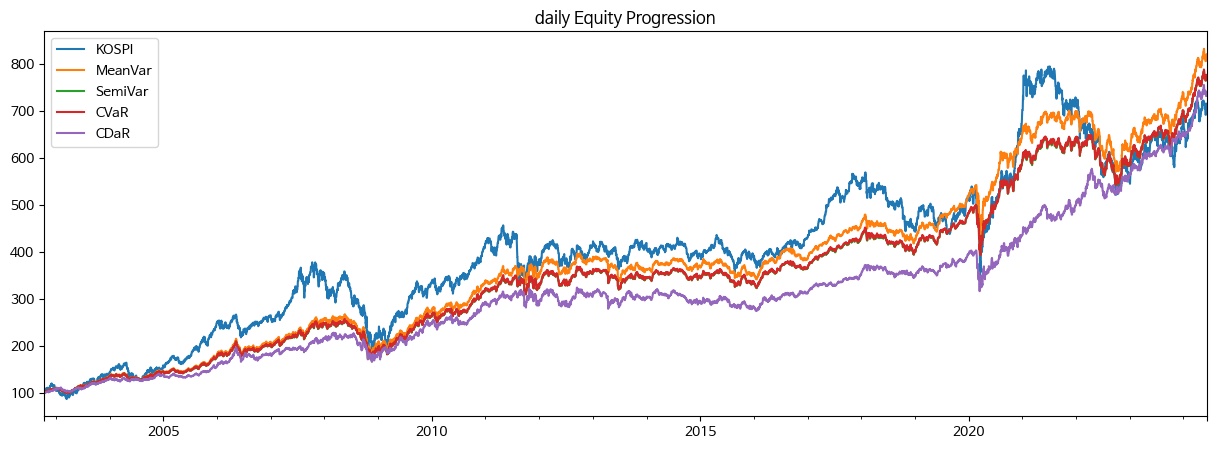

In [77]:
results.plot(freq='d');

In [78]:
results.stats.loc[metrics]

,KOSPI,MeanVar,SemiVar,CVaR,CDaR
total_return,6.154752,7.132219,6.7088,6.714507,6.330674
cagr,0.095145,0.101641,0.098924,0.098961,0.096374
max_drawdown,-0.526171,-0.351318,-0.347883,-0.350476,-0.268572
avg_drawdown,-0.035753,-0.019108,-0.017467,-0.017248,-0.018236
avg_drawdown_days,56.318182,30.632035,28.885246,29.161157,31.583333
daily_vol,0.207572,0.116886,0.113927,0.11403,0.126361
daily_sharpe,0.542248,0.887742,0.88609,0.885694,0.792358
daily_sortino,0.869322,1.420861,1.415628,1.416147,1.255685
monthly_vol,0.189367,0.119297,0.114532,0.114943,0.10975
monthly_sharpe,0.560419,0.861482,0.870275,0.86771,0.888096


## Portfolios

### Weights 1

In [96]:
df_etf

,273130,453850,284430,069500,379800,411060,305080,304660,148070
Date,,,,,,,,,
2002-10-14,NaN,NaN,NaN,5184,NaN,NaN,NaN,NaN,NaN
2002-10-15,NaN,NaN,NaN,5312,NaN,NaN,NaN,NaN,NaN
2002-10-16,NaN,NaN,NaN,5335,NaN,NaN,NaN,NaN,NaN
2002-10-17,NaN,NaN,NaN,5410,NaN,NaN,NaN,NaN,NaN
2002-10-18,NaN,NaN,NaN,5642,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-05-31,109945.0,8150.0,12830.0,36010,16455.0,14905.0,11895.0,7690.0,110855.0
2024-06-03,110245.0,8225.0,12885.0,36660,16540.0,14685.0,11860.0,7755.0,111245.0
2024-06-04,110605.0,8325.0,12895.0,36390,16500.0,14835.0,11930.0,7850.0,111850.0


In [97]:
df = get_start_dates(df_etf, etf_names)
df

,name,start date
069500,KODEX 200,2002-10-14
148070,KOSEF 국고채10년,2011-10-20
273130,KODEX 종합채권(AA-이상)액티브,2017-06-29
284430,KODEX 200미국채혼합,2017-11-30
305080,TIGER 미국채10년선물,2018-08-30
304660,KODEX 미국30년국채울트라선물(H),2018-09-12
379800,KODEX 미국S&P500TR,2021-04-09
411060,ACE KRX금현물,2021-12-15
453850,ACE 미국30년국채액티브(H),2023-03-14


In [98]:
#OrderedDict({'S&P': 0.30467, 'Gold': 0.44435, 'WTI': 0.0, 'US10YT': 0.0, 'US30YT': 0.0, 'KOSPI': 0.25098})
etf = ['379800', '411060', '069500']
weights = [0.3, 0.4, 0.3]
weights = dict(zip(etf, weights))

{etf_names[k]:v for k,v in weights.items()}

{'KODEX 미국S&P500TR': 0.3, 'ACE KRX금현물': 0.4, 'KODEX 200': 0.3}

In [99]:
df_slt = df_etf[etf]
df = get_start_dates(df_slt)
df

,start date
069500,2002-10-14
379800,2021-04-09
411060,2021-12-15


In [100]:
df_slt = df_slt.loc[df['start date'].max():].fillna(method='ffill')
df_slt.isna().sum()

379800    0
411060    0
069500    0
dtype: int64

In [101]:
df = df_slt
b1 = backtest(df, weights, 'ETF')

In [102]:
p = 'Q'
b2 = backtest(df, weights, f'ETF ({p})', p)

In [103]:
b0 = buy_and_hold(df['069500'], name_stg='KOSPI')

### Weights 2

In [106]:
df = get_start_dates(df_etf, etf_names)
df

,name,start date
069500,KODEX 200,2002-10-14
148070,KOSEF 국고채10년,2011-10-20
273130,KODEX 종합채권(AA-이상)액티브,2017-06-29
284430,KODEX 200미국채혼합,2017-11-30
305080,TIGER 미국채10년선물,2018-08-30
304660,KODEX 미국30년국채울트라선물(H),2018-09-12
379800,KODEX 미국S&P500TR,2021-04-09
411060,ACE KRX금현물,2021-12-15
453850,ACE 미국30년국채액티브(H),2023-03-14


In [107]:
etf = ['069500', '379800', '453850', '411060']
weights = [1, 1, 1, 1]
weights = dict(zip(etf, weights))

{etf_names[k]:v for k,v in weights.items()}

{'KODEX 200': 1,
 'KODEX 미국S&P500TR': 1,
 'ACE 미국30년국채액티브(H)': 1,
 'ACE KRX금현물': 1}

In [108]:
df_slt = df_etf[etf]
df = get_start_dates(df_slt)
df

,start date
069500,2002-10-14
379800,2021-04-09
411060,2021-12-15
453850,2023-03-14


In [109]:
df_slt = df_slt.loc[df['start date'].max():].fillna(method='ffill')
df_slt.isna().sum()

069500    0
379800    0
453850    0
411060    0
dtype: int64

In [110]:
df = df_slt
b3 = backtest(df, weights, 'ETF W2')

### Compare

,KOSPI,ETF,ETF (Q),ETF W2
total_return,0.208005,0.322408,0.317958,0.948147
cagr,0.164978,0.25335,0.249941,0.7141
max_drawdown,-0.122168,-0.040983,-0.041166,-0.266967
avg_drawdown,-0.025526,-0.009315,-0.009348,-0.060508
avg_drawdown_days,19.55,11.633333,11.7,24.25
daily_vol,0.156357,0.080731,0.080846,0.328494
daily_sharpe,1.083257,2.920419,2.881675,1.855217
daily_sortino,1.941102,5.642954,5.544603,3.149276
monthly_vol,0.165484,0.087861,0.087182,0.423852
monthly_sharpe,0.848347,2.264092,2.253331,1.256346


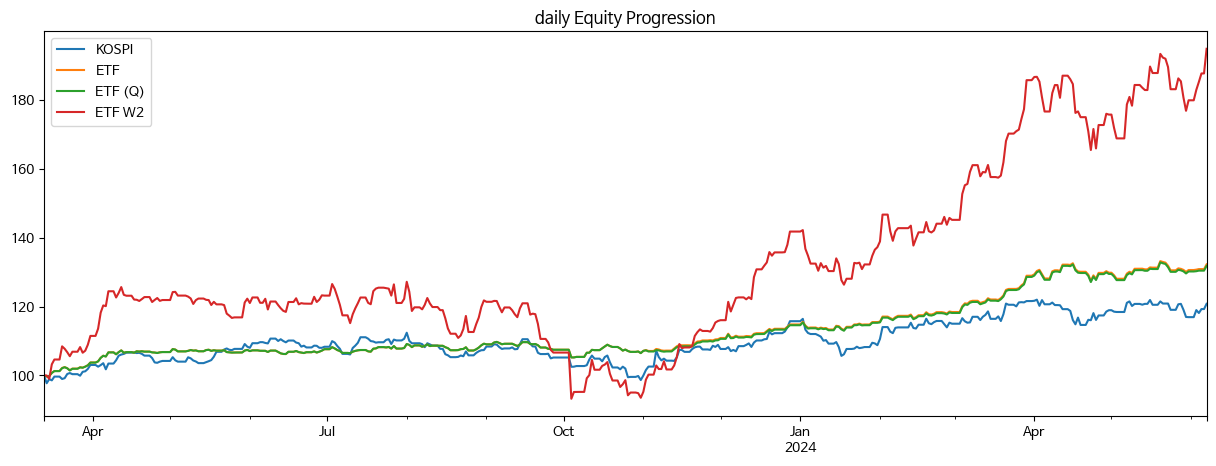

In [111]:
results = bt.run(b0, b1, b2, b3)
results.plot(freq='d');
results.stats.loc[metrics]